In [1]:
%load_ext autoreload
%autoreload 2
import sys
import torch
import math
import numpy as np
from torch import nn
sys.path.append('..')
from pathlib import Path
from typing import Union
from erank.data import get_metadataset_class
from omegaconf import OmegaConf
from torch.utils import data
from erank.utils import load_directions_matrix_from_task_sweep
import matplotlib.pyplot as plt
from erank.data.omniglotdataset import OmniglotDataset
from ml_utilities.data_utils import show_images
gpu_id = 0

/home/max/anaconda3/envs/erank/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Specify dataset directory etc.

In [2]:
data_dir = '/home/max/phd/data'
dataset_name = 'omniglot'
top_level_folders = [
    'images_background',  # original train data 
    'images_evaluation',  # original test data
]
dataset_split_toplevel_folders = {
    'train': 'images_background',
    'val': 'images_background',
    'test': 'images_evaluation'
}

## Check file directory

In [3]:
# check folders
dataset_dir = Path(data_dir) / dataset_name
toplevel_folders_disk = [d.stem for d in dataset_dir.iterdir() if d.is_dir()]
set(top_level_folders).issubset(set(toplevel_folders_disk))

True

In [4]:
# check num alphabets
background_alphabets = [a.stem for a in (dataset_dir/ 'images_background').iterdir()]
evaluation_alphabets = [a.stem for a in (dataset_dir/ 'images_evaluation').iterdir()]
len(background_alphabets), len(evaluation_alphabets)

(30, 20)

## Dataset initialization + data loading

In [5]:
ogds = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:05<00:00,  4.37it/s]


In [6]:
# number of classes
classes = list(ogds._data.keys())
len(classes)

883

In [7]:
# shape of data stored in dataset
imgs = ogds._data[classes[0]]
imgs.shape

(20, 1, 28, 28)

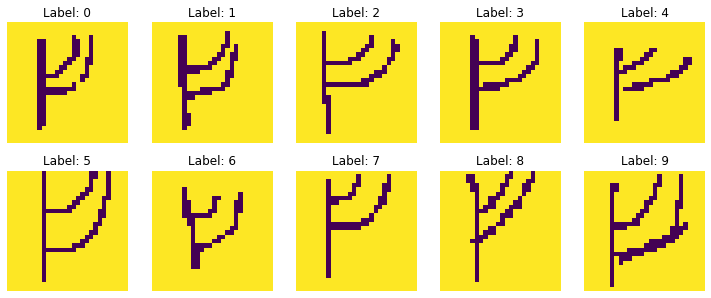

In [8]:
show_images(imgs, num_images=10, n_cols=5)

## Task generation

In [9]:
ogds.generate_pregen_tasks()
for t in ogds.pregen_tasks:
    print(t.name)

Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06
Arcadian--character18#Bengali--character02#Bengali--character28#Gujarati--character28#Latin--character08
Armenian--character03#Cyrillic--character05#Grantha--character12#Korean--character04#Latin--character01
Asomtavruli_(Georgian)--character38#Bengali--character06#Early_Aramaic--character01#Greek--character05#Japanese_(katakana)--character33
Cyrillic--character28#Futurama--character08#Latin--character13#Syriac_(Estrangelo)--character14#Tifinagh--character53


In [10]:
# different seed -> must sample other tasks, same seed -> same tasks OK
ogds1 = OmniglotDataset(data_root_path=data_dir,
                       n_way_classification=5,
                       support_size=5,
                       query_size=10,
                       num_tasks=5,
                       split='train',
                       dataset_layout='metadataset',
                       seed=0)

ogds1.generate_pregen_tasks()
for t in ogds1.pregen_tasks:
    print(t.name)

Loading Omniglot Alphabets: 100%|██████████| 25/25 [00:05<00:00,  4.75it/s]
Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06
Arcadian--character18#Bengali--character02#Bengali--character28#Gujarati--character28#Latin--character08
Armenian--character03#Cyrillic--character05#Grantha--character12#Korean--character04#Latin--character01
Asomtavruli_(Georgian)--character38#Bengali--character06#Early_Aramaic--character01#Greek--character05#Japanese_(katakana)--character33
Cyrillic--character28#Futurama--character08#Latin--character13#Syriac_(Estrangelo)--character14#Tifinagh--character53


In [11]:
ogds.get_tasks(num_tasks=1)[0].name, ogds1.get_tasks(num_tasks=1)[0].name

('Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06',
 'Arcadian--character05#Bengali--character19#Grantha--character07#Mkhedruli_(Georgian)--character03#Mkhedruli_(Georgian)--character06')

## Task support and query set sampling